# CS156 Assignment 3
**LBA: Principle Landmarks** | By `Korede Akande`

## Prompt
For this LBA you will need to take at least 20 photos of your favorite landmark. These photos need to be as close to identical as possible, but they need to be taken during the day and over a period of at least 4 hours. Something that creates a time-lapse of your favorite landmark would be ideal, but is not necessary.


## Background & Process
Skip to **`1.Library Importation`** for code

For this LBA, I have selected the [Berlin TV Tower (Fernsehturm Berlin)](https://en.wikipedia.org/wiki/Fernsehturm_Berlin) as my landmark. This was one of the first landmarks I saw on getting to Berlin – mostly because I get a really nice view of it from my room! The images used in assignment were conveniently taken from my bedside window, but before we get a glimpse of them, a discussion on my process:

### Process:
On Oct 21st from about 8:30am to 1pm, photos of the Berlin TV tower were taken with my phone camera, with successive photos coming between 5 to 30 minutes after each other. To restrict the image to the Berlin tower solely, the photos were taken with x5 zoom and other extraneous structures were cropped out of the shot. No other preprocessing steps (e.g. brightening) were carried out

---

### 1. Library Importation

In [2]:
from glob import glob
from PIL import Image, ImageOps
from resizeimage import resizeimage
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Load and process all photos down to a size not exceeding 512 pixels in either width or height 
`Assignment Task`

In [78]:
#Size to resize images to
img_size = [512,512]

#List to store the flattened/resized images
flattened_imgs = []

#Create path to the images
landmark_imgs = glob('photos/*.jpg')
    
#For each image path
for path in landmark_imgs:

    #Open it as a read file in binary mode
    with open(path, 'r+b') as f:

        #Open it as an image
        with Image.open(f) as image:
            
            #Keep image in original orientation
            image = ImageOps.exif_transpose(image)

            #Check if the image is too small
            if min(image.size) < min(img_size):

                #If it is, enlarge to the img_size
                cover = image.resize(img_size)

            else:
                #Resize the image to the specified size
                cover = resizeimage.resize_cover(image,img_size)

            #Flatten the matrix to an array and append it to flattened_imgs list
            flattened_imgs.append(np.array(cover).flatten())

#Flatten once more
flattened_imgs = np.asarray(flattened_imgs)   

### 3. Visualize a few of the preprocessed images

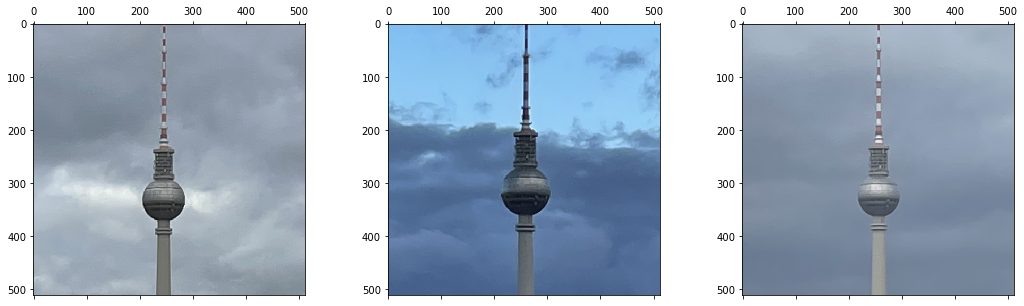

In [13]:
plt.figure(figsize=(18,5))
for idx,img_idx in enumerate([2,4,11]):
    plt.subplot(1,3,idx+1).matshow(flattened_imgs[img_idx].reshape((512,512,3)))
plt.show() 

### 4. Project the images down to a 2 dimensional representation using PCA
`Assignment Task`

In [14]:
#Run PCA with 2 principal components
pca = PCA(2)
pca.fit(flattened_imgs)

#Reduce the dimensionality of the images using the principal components
projected_imgs = pca.transform(flattened_imgs)

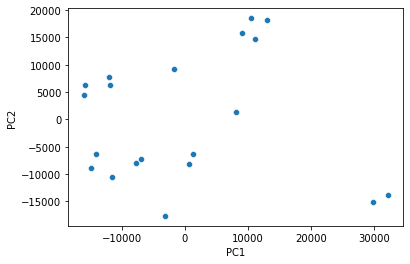

In [19]:
#Plot the principal components and visualize the location of all the images
sns.scatterplot(x= projected_imgs[:,0], y=projected_imgs[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### 5. Exploring the principal components/eigen-landmarks

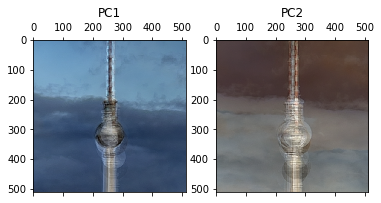

In [16]:
"""
Plot the eigenimage from the principal components

Adapted from (Avery,2015) Eigenstyle/visuals.py 
Retrieved from https://github.com/graceavery/Eigenstyle/blob/master/visuals.py
"""

for i in range(0,2):
    hi = max(pca.components_[i])
    lo = min(pca.components_[i])
    rescaled_pc = ((255*(pca.components_[i] - lo))/(hi-lo))
    reshaped_pc = rescaled_pc.reshape((512,512,3))
    plt.subplot(1,2,i+1,title=f"PC{i+1}").matshow(Image.fromarray(np.clip(reshaped_pc,0,255)\
                                         .astype(np.uint8)))

Trying to ascribe qualitative descriptions to the principal components, I have the following:
- **Component 1:** Blue sky (vs. grey sky)
- **Component 2:** The location of the spherical base 

In [17]:
print("PC1 and PC2 explain {:.3f} and {:.3f} of the variance, respectively.".format(*pca.explained_variance_ratio_))

PC1 and PC2 explain 0.332 and 0.217 of the variance, respectively.


From the above, we see that PC1 & PC2 jointly explain about 55% of the variance. Given the total variance explained, we might expect that the reconstructions won't be entirely accurate (we would certainly need more PCs for that!) but they should still be pretty decipherable

### 6. Show the reconstruction from each low-dimensional representation
`Assignment Task`

**A Small Subset of Images**

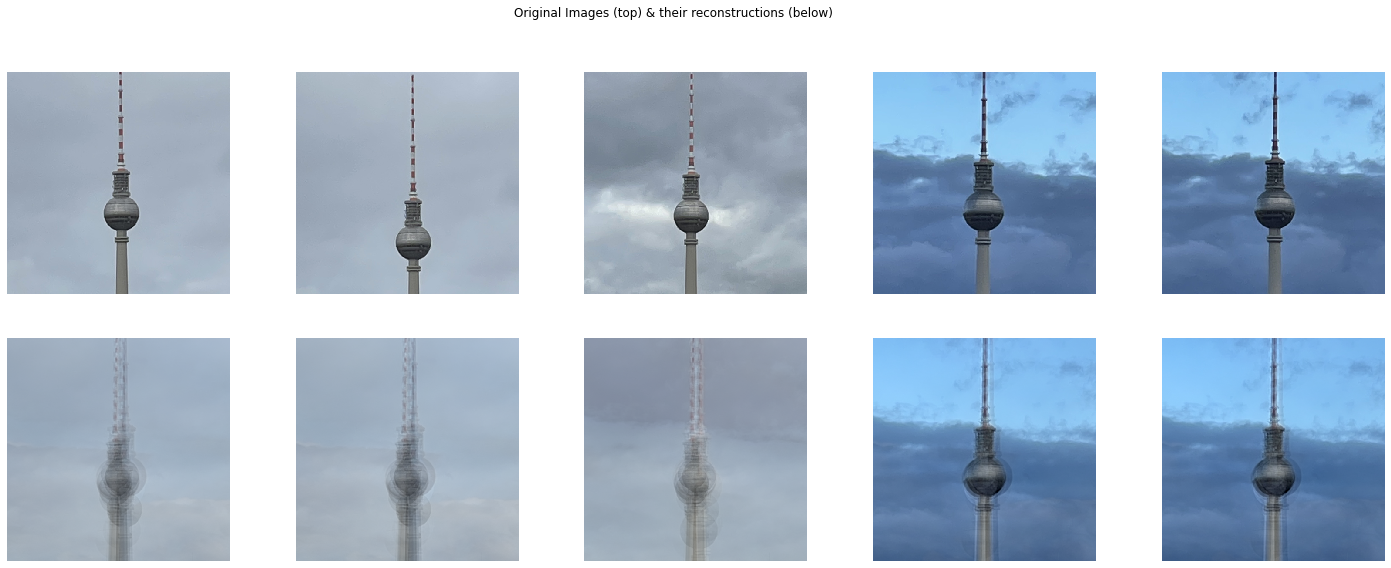

In [100]:
fig = plt.figure(figsize=(25,9))
fig.suptitle('Original Images (top) & their reconstructions (below)')

for idx in range(5):
    
    #Plot ten original images
    plt.subplot(2,5,idx+1).matshow(flattened_imgs[idx].reshape((512,512,3)))
    plt.axis('off')

    #Plot reconstruction of the original images
    img = pca.inverse_transform(projected_imgs[idx]).reshape((512,512,3))
    img = Image.fromarray(np.clip(img,0,255).astype(np.uint8))
    ax = fig.add_subplot(2, 5, 5+idx+1)
    ax.matshow(img)
    ax.axis('off')
    
plt.show()

**All Images**

In [88]:
def plot_imgs_and_reconstructions(original_array,projected_array,start_idx=0):
    
    """
    Function to plot 10 images and their reconstructions
    """
    
    fig = plt.figure(figsize=(18,5))
    fig.suptitle('Original Images (top) & their reconstructions (below)')
    fig.subplots_adjust(bottom=0.4, top=0.9, hspace=0.1)
    fig.tight_layout()
    
    for idx in range(10):
    
        #Plot ten original images
        plt.subplot(2,10,idx+1).matshow(original_array[start_idx+idx].reshape((512,512,3)))
        plt.axis('off')

        #Plot reconstruction of the original images
        img = pca.inverse_transform(projected_array[start_idx+idx]).reshape((512,512,3))
        img = Image.fromarray(np.clip(img,0,255).astype(np.uint8))
        ax = fig.add_subplot(2, 10, 10+idx+1)
        ax.matshow(img)
        ax.axis('off')
 

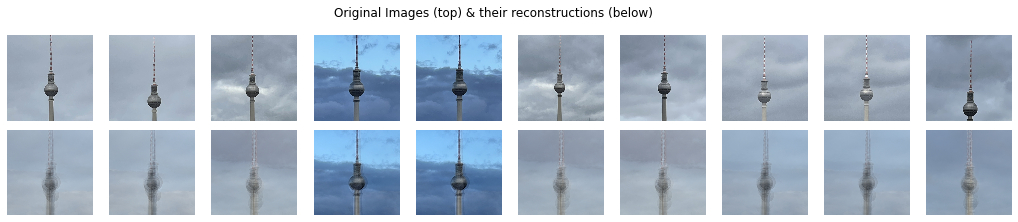

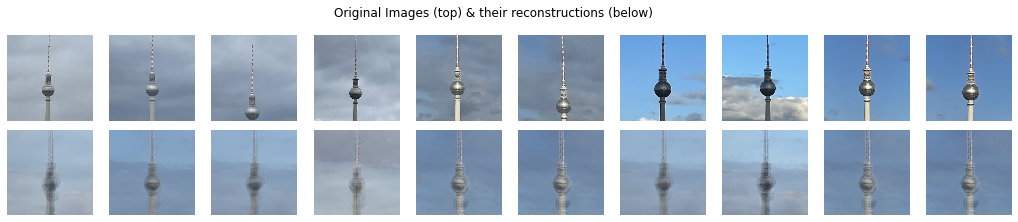

In [90]:
plot_imgs_and_reconstructions(flattened_imgs,projected_imgs)
plot_imgs_and_reconstructions(flattened_imgs,projected_imgs,10)
plt.show() 

From the reconstruction, the model seems to do a pretty good job determining sky colour (blue vs. grey sky) e.g. see 4th and 5th original images vs. the other images. However, it does poorer determing the position of the spherical base of the Berlin tower (e.g. see 10th and 13th original images). Note, though, that the true position of the spherical base in the images are often darker and more pronounced in the reconstructions

### 7. Pick a point that is far away from any known location
`Assignment Task`

I pick a point that has high values on both the PC1 and PC2 axes (see below). Based on my qualitative descriptions of both components above, I believe the reconstruction should have really blue sky and more uncertainty on the position of the spherical base

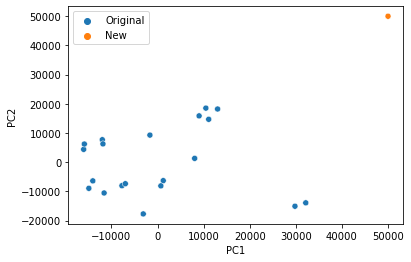

In [79]:
#Note the location of the new point
new_point = [50000,50000]

#Include labels to distinguish the original image points and the new point
labels = ['Original'] * len(projected_imgs)
labels.append('New')

#Plot the principal components and visualize the location of images and the new point 
sns.scatterplot(x= np.append(projected_imgs[:,0],new_point[0]), 
                y= np.append(projected_imgs[:,1],new_point[1]), hue = labels)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### 8. Plot the reconstruction of the picked point
`Assignment Task`

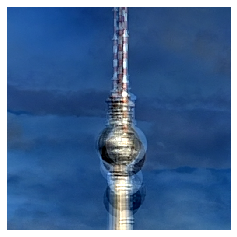

In [74]:
#Plot reconstruction of the new point
img = pca.inverse_transform(new_point).reshape((512,512,3))
img = Image.fromarray(np.clip(img,0,255).astype(np.uint8))
plt.matshow(img)
plt.axis('off')
plt.show()

We find that this is infact the case. The reconstruction has really blue sky in the background and multiple darker/texturized circles/spheres mimicking potential positions of the spherical base of the tower

## Conclusion

Based on this problem of reconstructing the Berlin tower with a lower representation, we can conclude that in high dimensional problems, PCA could be a helpful technique to implement because it helps reduce dimensionality (and noise) while retaining the important features. This could be especially helpful when we plan to run a process-intensive algorithm on high-dimensional data as it could help reduce the required computational expense (i.e. it helps with the curse of dimensionality). Additionally, we saw that by just reducing the images to 2D in PCA, we were able to generate pretty decipherable images of the Berlin tower such that people would likely be able to identify the landmark from the reconstructions! With more dimensions, the reconstructions should get even better and better!